# Empirical Probability Distributions

In the real world, we have a limited number of observations (not inifine numbers along a curve as in the theoretical examples). How do we know what our data looks like, what kind of distribution it has, what statistical tests we might what to use? 

One first step can be to create an empirical CDF and PDF from the data. (I find PDFs more intuitive, they resemble histograms, but which one you use to communicate some point depends on your audience and what what other engineers and scientists in your field typically use.) Wikipedia is a good place to start to learn more about [empirical distributions](https://en.wikipedia.org/wiki/Empirical_distribution_function).

Let's import some packages we'll need, and load a sample dataset.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define the filepath and filename of the file with our data
Skykomish_data_file = 'Skykomish_peak_flow_12134500_skykomish_river_near_gold_bar.xlsx'
# Use pandas.read_excel() function to open this file.
Skykomish_data = pd.read_excel(Skykomish_data_file)
# take a look at the first few rows
Skykomish_data.head(3)

,date of peak,water year,peak value (cfs),gage_ht (feet)
0,1928-10-09,1929,18800,10.55
1,1930-02-05,1930,15800,10.44
2,1931-01-28,1931,35100,14.08


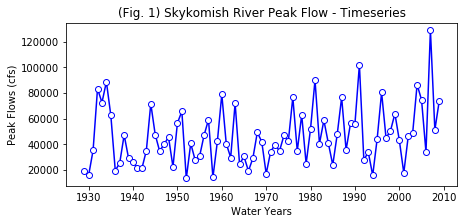

In [3]:
# Create a new figure for a timeseries plot
plt.figure(figsize=(7,3))

# Use the plot() function to plot the year on the x-axis, peak flow values on
# the y-axis with an open circle representing each peak flow value.
plt.plot(Skykomish_data['water year'], # our x value
         Skykomish_data['peak value (cfs)'], # our y value
         linestyle='-', # plot a solid line
         color='blue', # make the line color blue
         marker='o', # also plot a circle for each data point
         markerfacecolor='white',  # make the circle face color white
         markeredgecolor='blue') # make the circle edge color blue

# Label the axes and title.
plt.xlabel('Water Years')
plt.ylabel('Peak Flows (cfs)')
plt.title('(Fig. 1) Skykomish River Peak Flow - Timeseries');

---
## Estimating CDFs from Observations:

**Steps to estimate a CDF from observations:**
1. Rank the observed sample data from highest to lowest
2. Apply an "unbiased quantile estimator" to the ranked data. (There are many options here, we won't go into detail, but in our class we will use the Cunnane Quantile Estimator. This is recommended for hydrology applications (see [Helsel et al., 2020](https://pubs.er.usgs.gov/publication/tm4A3), Chapter 2, Table 2.2) Check if there are other unbiased quentile estimators used in your specific field.

**Cunnane Quantile Estimator**: Approximate quantile unbiased

Where $p_i$ is the calculated probability (estimated quantile) of the $i$th ranked observation, from a sample size of $n$.

$p_i = \displaystyle\frac{i-\,^2/_5}{n+\,^1/_5}$

Some advantages of using quantile plots (from Helsel et al., 2020):
- Arbitrary categories (bins) are not required, as they are with histograms
- All of the data are displayed, unlike a boxplot
- Every point has a distinct position without overlap

**Note:** In hydrology, you will often see "Probability of Exceedance" (important for reporting flood probabilities!). A typical CDF is 1-quantile, or the probability of value $\leq$ given value, as in our example below.

Take a look at the documentation for the [scipy.stats.mstats.mquantile()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.mquantiles.html) function. Or see the function I wrote below.

In [4]:
def cunnane_quantile(df, column_name):
    '''This function will compute the Cunnane plotting position for the values in a column of a dataframe.
    It requres a pandas dataframe, and the column name of interest (a text string) as inputs.
    The output is a new dataframe, ranked (sorted) with an extra column with the plotting position.'''
    
    # Rank all our values
    ranked_df = df.sort_values(by=[column_name]).reset_index()
    
    # Calculate the Cunnane plotting position
    ranked_df['cunnane_plotting_position'] = ((ranked_df.index + 1) - (2/5)) / (ranked_df[column_name].count() + (1/5))
        
    return ranked_df

Use the function above to create and plot an empirical CDF with our observations of peak flow from the Skykomish River.

In [5]:
# Compute a CDF from our observed data
ranked_df = cunnane_quantile(Skykomish_data,'peak value (cfs)')

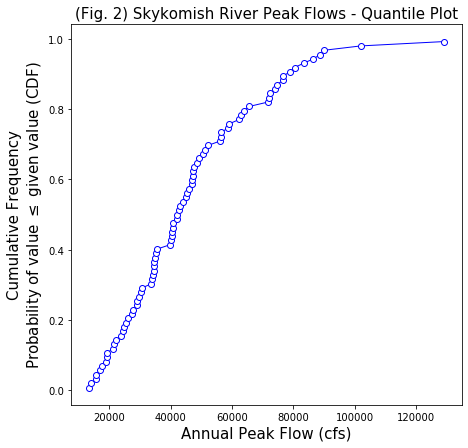

In [6]:
# Create a new figure for the quantile plot
fig, ax = plt.subplots(figsize=(7,7))
# Plot the ranked data against the plotting position
ranked_df.plot(x='peak value (cfs)',y='cunnane_plotting_position', 
               linestyle='-', lw=1, 
               marker='o', markerfacecolor='white', markeredgecolor='b', 
               color='b', ax=ax, legend=False)

# Label the axes and title.
ax.set_xlabel('Annual Peak Flow (cfs)', fontsize=15)
ax.set_ylabel('Cumulative Frequency\nProbability of value $\leq$ given value (CDF)', fontsize=15)
ax.set_title('(Fig. 2) Skykomish River Peak Flows - Quantile Plot',  fontsize=15);

We can also create a theoretical normal distribution based on our observations. By plotting the theoretical CDF next to our empirical CDF, we can see how close our observations match a normal distribution visually.

In [7]:
# To create the theoretical CDF, we need the sample values, the mean, and standard deviation of our data set
sample_values = Skykomish_data['peak value (cfs)'].sort_values() # sort our data
sample_mean = Skykomish_data['peak value (cfs)'].mean()
sample_std = Skykomish_data['peak value (cfs)'].std(ddof=1) # Note our ddof=1 here

# Create a theoretical normal CDF based on our sample values
normal_cdf = stats.norm.cdf(sample_values, sample_mean, sample_std)

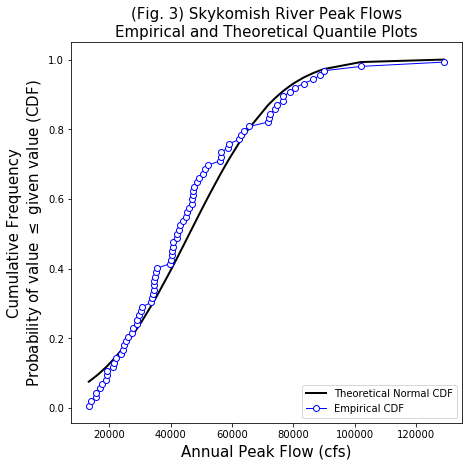

In [8]:
fig, ax = plt.subplots(figsize=(7,7))

# Theoretical CDF
plt.plot(sample_values,normal_cdf,'k-', lw=2, label='Theoretical Normal CDF')

# Empirical CDF
ranked_df.plot(x='peak value (cfs)',y='cunnane_plotting_position', 
               linestyle='-', lw=1, 
               marker='o', markerfacecolor='white', markeredgecolor='b', 
               color='b', ax=ax, legend=False, label='Empirical CDF')

# Label the axes and title.
plt.legend(loc='lower right')
ax.set_xlabel('Annual Peak Flow (cfs)', fontsize=15)
ax.set_ylabel('Cumulative Frequency\nProbability of value $\leq$ given value (CDF)', fontsize=15)
ax.set_title('(Fig. 3) Skykomish River Peak Flows\nEmpirical and Theoretical Quantile Plots',  fontsize=15);

---
## Estimating PDFs from Observations

**Options for estimating a PDF from observations:**
* Take the drivative, or difference between each step, on the CDF (CDF is the integral of the PDF)
* Create a histogram, normalize so that the area under the curve = 1

**Note:** PDFs can look different depending on how you're "binning" ([see descriptions here](https://en.wikipedia.org/wiki/Histogram#Number_of_bins_and_width)). CDFs can be less ambiguous, that's why they're typically recommended. You're using the PDF to communicate with an audience, so make sure it visually shows what you're trying to communicate

Take a look at the documentation for [numpy.histogram()](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html) and the density=True option.

In [9]:
# Compute a histogram, specifying density=True to get normalized values (integral=1)
counts, bin_edges = np.histogram(Skykomish_data['peak value (cfs)'], bins=10, density=True)

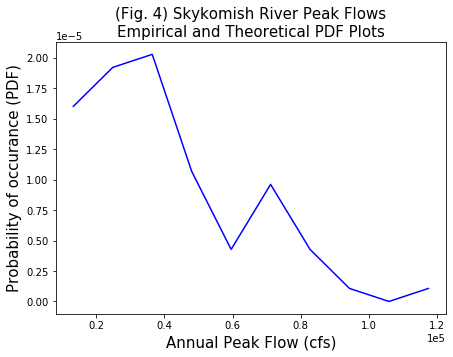

In [10]:
# Create a new figure for a timeseries plot
fig, ax = plt.subplots(figsize=(7,5))

ax.plot(bin_edges[:-1],counts,color='b')

# Label the axes and title.
ax.set_xlabel('Annual Peak Flow (cfs)', fontsize=15)
ax.set_ylabel('Probability of occurance (PDF)', fontsize=15)
ax.set_title('(Fig. 4) Skykomish River Peak Flows\nEmpirical and Theoretical PDF Plots',  fontsize=15);
# use scientific notation on axes
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))